# Training a generative adversarial network to produce resistivity logs

Here we train a GAN on resistivity well logs from the Kansas Geological Survey

## Imports

In [0]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from IPython import display

from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, Flatten, Reshape
from keras.layers import Conv1D, Conv2DTranspose, ZeroPadding1D, UpSampling1D
from keras.layers import LeakyReLU, Dropout
from keras.layers import BatchNormalization, Lambda
from keras.optimizers import Adam, RMSprop, SGD
from keras import backend as K



Using TensorFlow backend.


Create a folder to store results in

In [0]:
run = 't1'
if not os.path.exists(run):
    os.makedirs(run)

Data is stored in a github repo for easy access here

In [0]:
# load data
if not os.path.exists('KGS_RILD_60ft'):
    ! git clone https://github.com/MLGeophysics/KGS_RILD_60ft.git
x_train = np.load('KGS_RILD_60ft/KSG_RILD_60ft.npy')

In [0]:
# Add channel axis
x_train = np.expand_dims(x_train, axis=2)
# convert to log resistivity
x_train = np.log10(x_train)
# normalize data between -1 and 1
min_data = min(x_train.flatten())
max_data = max(x_train.flatten())
data_diff = max_data - min_data
# pad by norm_pad, so that a bunch of values don't end up at -1
norm_pad = 0.1
norm_diff = data_diff*(1.+norm_pad*2)
norm_min = min_data-data_diff*norm_pad
x_train = 2*(x_train-norm_min)/norm_diff-1.

x_train.shape

(4005, 60, 1)

## Architecture of discriminator and generator

Input/output shapes, choice of optimizer

In [0]:
samples_per_log = x_train.shape[1] # 60
channels = 1
latent_dim = 100
optimizer = Adam(0.0002, 0.5)

Instructions for updating:
Colocations handled automatically by placer.


Define a binary accuracy metric that works for soft labels(not only 0 or 1).

In [0]:
def soft_binary_accuracy(y_true, y_pred):
    ''' get accuracy even using soft labels '''
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

The discriminator takes in a well log, feeds it through several convolutional layers and a final dense layer, and outputs a value between 0 and 1.

In [0]:
# Build and compile the discriminator
# self.discriminator = self.build_discriminator()

D = Sequential()
depth = 8
ks = 5
dropout = 0.25

# In: 60 x 1, depth = 1
# Out: 30 x 1, depth=8
input_shape = (samples_per_log, channels)
D.add(Conv1D(depth*1, kernel_size=ks, strides=2, input_shape=input_shape, padding='same'))
D.add(LeakyReLU(alpha=0.2))
D.add(Dropout(rate=dropout))

# In: 30 x 1, depth=8
# Out: 15 x 1, depth=16
D.add(Conv1D(depth*2, kernel_size=ks, strides=2, padding='same'))
D.add(BatchNormalization(momentum=0.8))
D.add(LeakyReLU(alpha=0.2))
D.add(Dropout(rate=dropout))

# In: 15 x 1, depth=16
# Out: 8 x 1, depth=32
D.add(ZeroPadding1D(padding=(0,1)))
D.add(Conv1D(depth*4, kernel_size=ks, strides=2, padding='same'))
D.add(BatchNormalization(momentum=0.8))
D.add(LeakyReLU(alpha=0.2))
D.add(Dropout(rate=dropout))

# In: 8 x 1, depth=32
# Out: 4 x 1, depth=64
D.add(Conv1D(depth*8, kernel_size=ks, strides=2, padding='same'))
D.add(BatchNormalization(momentum=0.8))
D.add(LeakyReLU(alpha=0.2))
D.add(Dropout(rate=dropout))

# Out: 1-dim probability
D.add(Flatten())
D.add(Dense(1, activation='sigmoid'))

D.summary()

img = Input(shape=input_shape)
validity = D(img)

discriminator = Model(img,validity)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 30, 8)             48        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 30, 8)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 8)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 15, 16)            656       
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 16)            64        
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 15, 16)            0         
___________________________

Compile the generator, using the custom-defined metric and the optimizer specified above.

In [0]:
discriminator.compile(loss='binary_crossentropy',
                           optimizer=optimizer,
                           metrics=[soft_binary_accuracy])

The Generator takes a 100 element vector of numbers drawn randomly from a normal distribution, and outputs a 60-sample RILD well log

In [0]:
#def build_generator(self):
G = Sequential()
depth = 32
ks = 5
dropout = 0.25
dim = 15

# In: 100
# Out: 15 x 32
G.add(Dense(dim*depth, input_dim=latent_dim))
G.add(LeakyReLU(alpha=0.2))
# add a dimension to use Conv2DTranspose (Conv1DTranspose doesn't exist)
G.add(Reshape((dim, 1, depth)))

# In: 15 x 1 x 32
# Out: 30 x 1 x 16
G.add(Conv2DTranspose(filters=depth//2,kernel_size=(ks,1),strides=(2,1),padding='same'))
G.add(BatchNormalization(momentum=0.8))
G.add(LeakyReLU(alpha=0.2))

# In: 30 x 1 x 16
# Out: 60 x 1 x 8
G.add(Conv2DTranspose(filters=depth//4,kernel_size=(ks,1),strides=(2,1), padding='same'))
G.add(BatchNormalization(momentum=0.8))
G.add(LeakyReLU(alpha=0.2))

# In: 60 x 1 x 8
# Out: 60 x 1 property image
G.add(Reshape((samples_per_log,-1)))
G.add(Conv1D(channels, ks, strides=1, padding='same'))
G.add(Activation('tanh'))
G.summary()

noise = Input(shape=(latent_dim,))
img = G(noise)

generator = Model(noise,img)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 480)               48480     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 480)               0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 15, 1, 32)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 30, 1, 16)         2576      
_________________________________________________________________
batch_normalization_4 (Batch (None, 30, 1, 16)         64        
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 30, 1, 16)         0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 60, 1, 8)          648       
__________

Build the generator, but do not compile. We compile the combined generator-discriminator

In [0]:
# The generator takes noise as input and generates imgs
z = Input(shape=(latent_dim,))
img = generator(z)

# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
valid = discriminator(img)

# The combined model  (stacked generator and discriminator)
# trains the generator to fool the discriminator
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', 
                      optimizer=optimizer,
                      metrics=[soft_binary_accuracy])

discriminator.trainable = True

In [0]:
def plot_16_images(images, save2file=False, folder='.', epoch=0, xlim=[-1,1]):
    '''
    plot 16 logs in a 4x4 grid
    if epoch < 0, assume they are training logs
    otherwise, assume they're generated after training epoch # epoch
    '''
    fake = epoch >= 0
    if fake:
        filename = folder+"/RILD_%05d.png" % epoch
    else:
        filename = folder+'/RILD_train_examples.png'

    plt.figure(figsize=(10,10))
    
    for i in range(images.shape[0]):
        plt.subplot(4, 4, i+1)
        image = images[i]
        plt.plot(image,np.arange(len(image)))
        plt.xlim(xlim)
        plt.gca().invert_yaxis()
    plt.tight_layout(rect=[0,0.03,1,0.95])
    if fake:
        plt.suptitle('Epoch %d'%epoch)
    if save2file:
        plt.savefig(filename)
        plt.close('all')
    else:
        display.display(plt.gcf())
        display.clear_output(wait=True)
        plt.close('all')
        #plt.show()

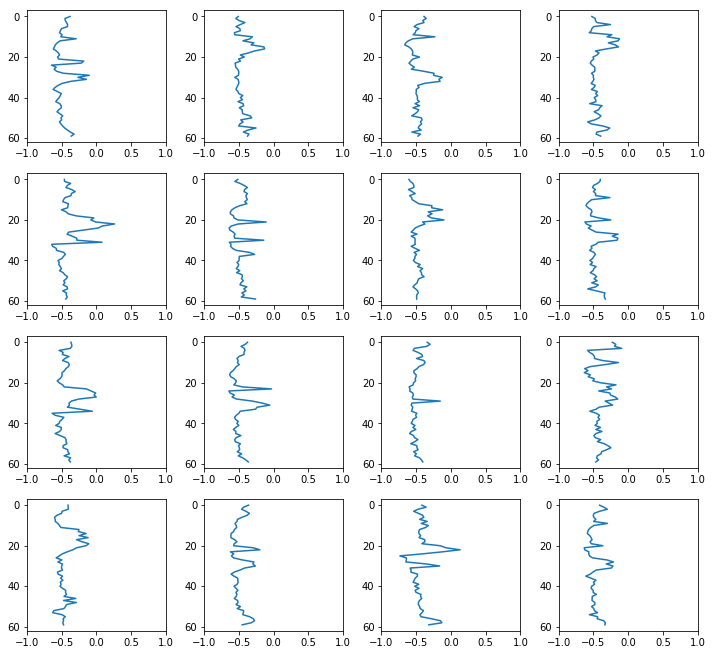

In [0]:
# plot training data
i_plt_logs = np.random.randint(0,x_train.shape[0],16)
plot_16_images(x_train[i_plt_logs], save2file=True, folder=run, epoch=-1)
plot_16_images(x_train[i_plt_logs], save2file=False, folder=run, epoch=-1)

## Define training hyperparameters

In [0]:
# Specify training hyperparameters

epochs=20000
batch_size=32
save_interval=50

# max value for soft labels
softness = 0.1

# number of swapped labels for noisy discriminator labels
noisy_labels = False
noise_level = 0.05
num_noise = int(batch_size*noise_level)

# size of experience replay vector
exp_size = 100
# rate of replacement of vector
# mean age of image ~= 1/exp_update_rate
# max age of image ~= 250 for exp_size=100, exp_update_rate = .02
exp_update_rate=  0.02
num_update_exp = int(exp_size*exp_update_rate)
exp_train = 0.2
num_exp = int(batch_size*exp_train)

In [0]:
# Adversarial ground truths
fake = np.ones((batch_size, 1))
valid = np.zeros((batch_size, 1))

# Save random noise for plots
noise_input = np.random.normal(0, 1, size=[16, latent_dim])
plt_images = generator.predict(noise_input)
plot_16_images(plt_images,save2file=True,folder=run,epoch=0)

# Save metadata and metrics
metrics = np.empty((epochs,5))
logfile = run+'/log.txt'
with open(logfile,'w') as lf:
    discriminator.summary(print_fn=lambda x: lf.write(x+'\n'))
    D.summary(print_fn=lambda x: lf.write(x+'\n'))
    generator.summary(print_fn=lambda x: lf.write(x+'\n'))
    G.summary(print_fn=lambda x: lf.write(x+'\n'))

# Initialize experience replay vector
batch_noise = np.random.normal(0,1, (exp_size,latent_dim))
exp_images = generator.predict(batch_noise)

## Train

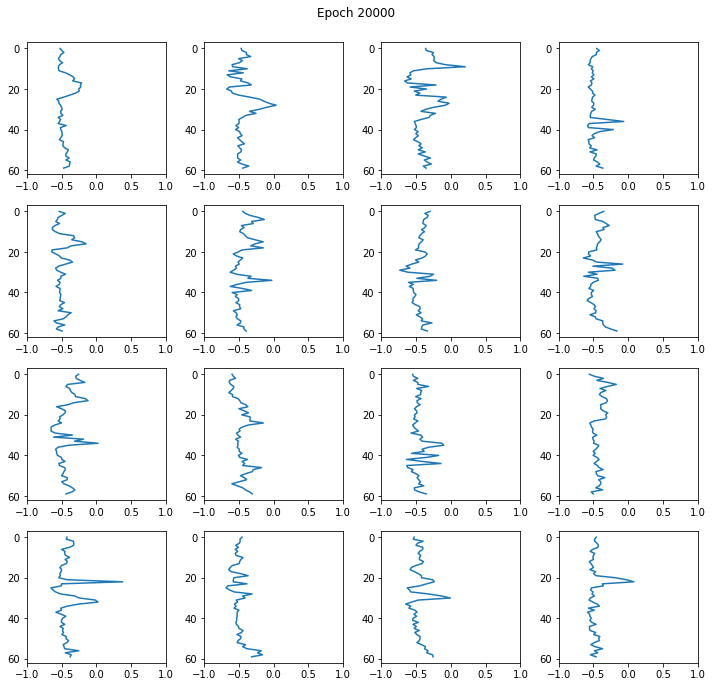

In [0]:
for epoch in range(epochs):
    # ---------------------
    #  Train Discriminator
    # ---------------------

    # Select a random batch of images
    idx = np.random.randint(0, x_train.shape[0], batch_size)
    imgs = x_train[idx]

    # Sample noise and generate a batch of new images
    batch_noise = np.random.normal(0, 1, (batch_size, latent_dim))
    gen_imgs = generator.predict(batch_noise)

    # Load a few old generated images
    i_choose_exp = np.random.randint(0,exp_size,num_exp)
    i_swap_exp = np.random.randint(0,batch_size,num_exp)
    gen_imgs[i_swap_exp] = exp_images[i_choose_exp]

    # Soft labels for discriminator
    discriminator_fake = np.random.uniform(1.-softness,1.,(batch_size,1))
    discriminator_valid = np.random.uniform(0.,softness,(batch_size,1))

    if noisy_labels:
        # Noisy labels for discriminator
        i_swap = np.random.randint(0,batch_size,num_noise)
        discriminator_fake[i_swap] = np.random.uniform(0.,softness,(num_noise,1))
        discriminator_valid[i_swap] = np.random.uniform(1.-softness,1.,(num_noise,1))

    # Train the discriminator (real classified as ones and generated as zeros)
    d_loss_real = discriminator.train_on_batch(imgs, discriminator_valid)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, discriminator_fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # ---------------------
    #  Train Generator
    # ---------------------

    # Train the generator (wants discriminator to mistake images as real)
    g_loss = combined.train_on_batch(batch_noise, valid)

    # Plot and save the progress
    metric = (epoch, d_loss[0], 100*d_loss[1], g_loss[0], 100*g_loss[1])
    # print_line = "%d [D loss: %f, acc.: %.2f%%] [G loss: %f, acc.: %.2f%%]" % metric
    # print (print_line)
    # with open(logfile,'a') as lf:
    #     lf.write(print_line+'\n')
    metrics[epoch] = metric

    # If at save interval => save generated image samples
    if (1+epoch) % save_interval == 0:
        #discriminator.save(run+'/discriminator_%05d.h5'%(1+epoch))
        #combined.save(run+'/combined_%05d.h5'%(1+epoch))
        #generator.save(run+'/generator_%05d.h5'%(1+epoch))
        plt_images = generator.predict(noise_input)
        plot_16_images(plt_images,save2file=False, folder=run, epoch=1+epoch)
        #np.save(run+'/metrics.npy',metrics)
        #np.savetxt(run+'/metrics.txt',metrics)

    # update experience replay vector
    i_update_exp = np.random.randint(0,exp_size,num_update_exp)
    exp_noise = np.random.normal(0,1,(num_update_exp,latent_dim))
    exp_images[i_update_exp] = generator.predict(exp_noise)
# save results and metrics
discriminator.save(run+'/discriminator_final.h5')
combined.save(run+'/combined_final.h5')
generator.save(run+'/generator_final.h5')
np.save(run+'/metrics.npy',metrics)
np.savetxt(run+'/metrics.txt',metrics)
plt_images = generator.predict(noise_input)
plot_16_images(plt_images,save2file=True, folder=run, epoch=1+epoch)

## Analyze results

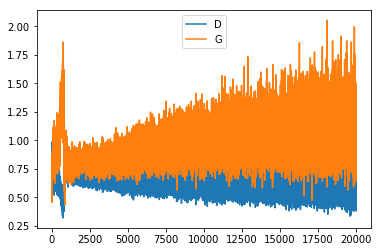

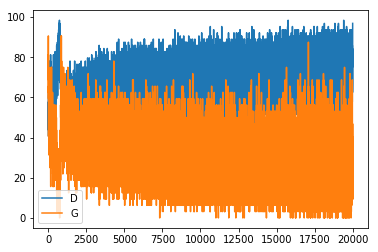

In [19]:
# plot loss
plt.plot(metrics[:,0],metrics[:,1])
plt.plot(metrics[:,0],metrics[:,3])
plt.legend(['D','G'])
plt.show()

# plot accuracy
plt.plot(metrics[:,0],metrics[:,2])
plt.plot(metrics[:,0],metrics[:,4])
plt.legend(['D','G'])
plt.show()

Compare statistics of generator output and training data

In [20]:
# Generate as many synthetic logs as there are training logs
gen_logs_input = np.random.normal(0,1,(x_train.shape[0],latent_dim))
gen_logs = generator.predict(gen_logs_input)
gen_logs.shape

(4005, 60, 1)

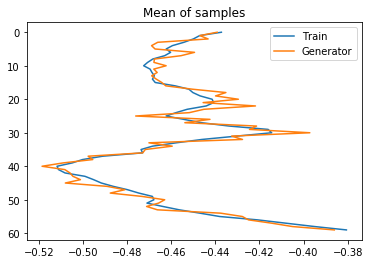

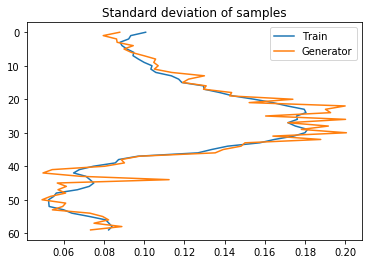

In [21]:
# means
plt.plot(np.mean(x_train[:,:,0],axis=0),np.arange(60))
plt.plot(np.mean(gen_logs[:,:,0],axis=0),np.arange(60))
plt.gca().invert_yaxis()
plt.legend(['Train','Generator'])
plt.title('Mean of samples')
plt.show()

# standard deviations
plt.plot(np.std(x_train[:,:,0],axis=0),np.arange(60))
plt.plot(np.std(gen_logs[:,:,0],axis=0),np.arange(60))
plt.gca().invert_yaxis()
plt.legend(['Train','Generator'])
plt.title('Standard deviation of samples')
plt.show()